In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class_map = {
    "colon_aca": 0,
    "colon_n": 1
}

colon_dir = "E:/cancer_dl/LC25000/lung_colon_image_set/colon_image_sets"
all_dirs = [colon_dir]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.74, 0.58, 0.70],
                         std=[0.12, 0.15, 0.13])
])

class ColonDataset(Dataset):
    def __init__(self, root_dir, class_map, transform=None):
        self.samples = []
        self.transform = transform
        for class_name in os.listdir(root_dir):
            folder = os.path.join(root_dir, class_name)
            if os.path.isdir(folder):
                for img_name in os.listdir(folder):
                    self.samples.append((os.path.join(folder, img_name), class_map[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

dataset = ColonDataset(colon_dir, class_map, transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [5]:
print(f"Total dataset size: {len(dataset)}")
print(f"Training set: {len(train_set)} samples ({len(train_set) / len(dataset) * 100:.1f}%)")
print(f"Validation set: {len(val_set)} samples ({len(val_set) / len(dataset) * 100:.1f}%)")
print(f"Test set: {len(test_set)} samples ({len(test_set) / len(dataset) * 100:.1f}%)")


Total dataset size: 10000
Training set: 7000 samples (70.0%)
Validation set: 2000 samples (20.0%)
Test set: 1000 samples (10.0%)


In [7]:
import torch.nn as nn
from torchvision.models import convnext_tiny, swin_t

class ConvNeXtEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = convnext_tiny(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        return self.pool(x).flatten(1)

class SwinEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = swin_t(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.norm = backbone.norm
        self.avgpool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.features(x)
        x = x.permute(0, 3, 1, 2).flatten(2).permute(0, 2, 1)
        x = self.norm(x).permute(0, 2, 1)
        x = self.avgpool(x)
        return x.squeeze(-1)

class HybridClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.cnn = ConvNeXtEncoder()
        self.swin = SwinEncoder()
        self.fusion = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        swin_feat = self.swin(x)
        feats = torch.cat([cnn_feat, swin_feat], dim=1)
        return self.fusion(feats)


In [9]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridClassifier(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%")


Epoch [1/10], Loss: 0.2190, Acc: 99.29%
Epoch [2/10], Loss: 0.2017, Acc: 99.93%
Epoch [3/10], Loss: 0.2030, Acc: 99.87%


KeyboardInterrupt: 

In [12]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set model to eval mode
model.eval()

# Collect predictions and labels
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


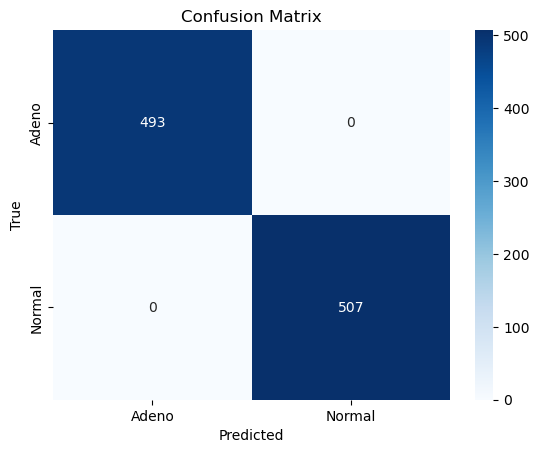

Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       493
     colon_n       1.00      1.00      1.00       507

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [14]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adeno', 'Normal'], yticklabels=['Adeno', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['colon_aca', 'colon_n']))


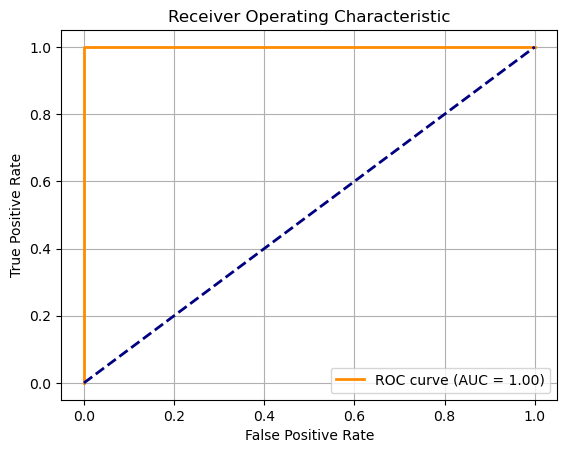

In [16]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


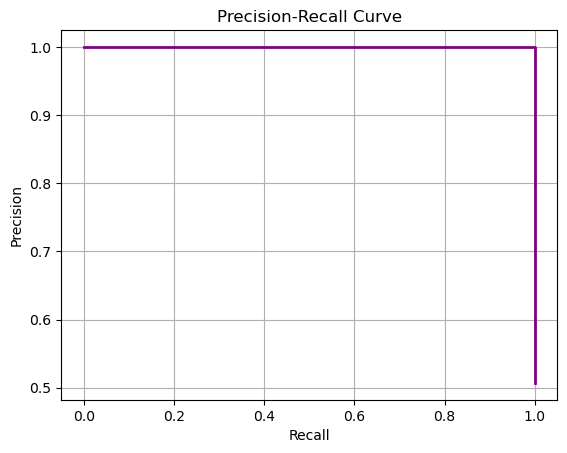

In [18]:
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()


In [22]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

val_acc = 100. * val_correct / val_total
print(f"Validation Acc: {val_acc:.2f}%")


Validation Acc: 100.00%


In [24]:
torch.save(model.state_dict(), "hybrid_colon_main_model.pth")
print("Model saved as hybrid_lung_model.pth")

Model saved as hybrid_lung_model.pth
